# Tutorial 8: Modelling tabular data with diffusion models

This tutorial demonstrates hot to use a denoising diffusion probabilistic model (DDPM) to synthesize tabular data. The algorithm was proposed in [TabDDPM: Modelling Tabular Data with Diffusion Models](https://arxiv.org/abs/2209.15421).

In [1]:
# stdlib
import sys
import warnings

# third party
import numpy as np
from sklearn.datasets import load_iris, load_diabetes

# synthcity absolute
import synthcity.logger as log
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import GenericDataLoader

log.add(sink=sys.stderr, level="INFO")
warnings.filterwarnings("ignore")

[KeOps] Warning : 
    The default C++ compiler could not be found on your system.
    You need to either define the CXX environment variable or a symlink to the g++ command.
    For example if g++-8 is the command you can do
      import os
      os.environ['CXX'] = 'g++-8'
    
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


## Synthesize a classification dataset

For classification datasets, TabDDPM automatically uses the labels as the conditional variable during training. You should not provide an additional `cond` argument to the `fit` method.

In [2]:
# Note: preprocessing data with OneHotEncoder or StandardScaler is not needed or recommended. Synthcity handles feature encoding and standardization internally.

X, y = load_iris(return_X_y=True, as_frame=True)
X["target"] = y

loader = GenericDataLoader(X, target_column="target", sensitive_columns=[])

loader.dataframe().head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
y.value_counts()

0    50
1    50
2    50
Name: target, dtype: int64

### Model fitting

In [4]:
# define the model hyper-parameters
plugin_params = dict(
    is_classification = True,
    n_iter = 1000,  # epochs
    lr = 0.002,
    weight_decay = 1e-4,
    batch_size = 1000,
    model_type = "mlp",  # or "resnet"
    num_timesteps = 500,  # timesteps in diffusion
    n_layers_hidden = 3,
    dim_hidden = 256,
    dim_embed = 128,
    dropout = 0.0,
    # performance logging
    log_interval = 10,
    print_interval = 100,
)

plugin = Plugins().get("ddpm", **plugin_params)
plugin.fit(loader)

[2023-03-31T00:29:29.172830+0200][10148][INFO] Encoding sepal length (cm) 8461685668942494555


TypeError: __init__() got an unexpected keyword argument 'n_components'

In [ ]:
plugin.model

TabDDPM(
  (diffusion): GaussianMultinomialDiffusion(
    (denoise_fn): MLPDiffusion(
      (emb_nonlin): SiLU()
      (proj): Linear(in_features=4, out_features=128, bias=True)
      (time_emb): TimeStepEmbedding(
        (fc): Sequential(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): SiLU()
          (2): Linear(in_features=128, out_features=128, bias=True)
        )
      )
      (label_emb): Embedding(3, 128)
      (model): MLP(
        (model): Sequential(
          (0): LinearLayer(
            (model): Sequential(
              (0): Linear(in_features=128, out_features=256, bias=True)
              (1): ReLU()
            )
          )
          (1): LinearLayer(
            (model): Sequential(
              (0): Linear(in_features=256, out_features=256, bias=True)
              (1): ReLU()
            )
          )
          (2): LinearLayer(
            (model): Sequential(
              (0): Linear(in_features=256, out_features=256, bias=

<AxesSubplot: xlabel='step'>

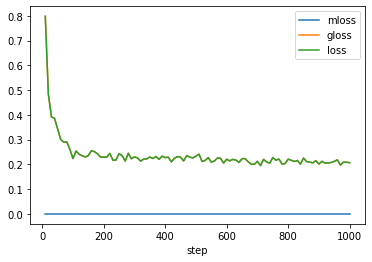

In [ ]:
# plot training curves
plugin.loss_history.plot()

### Data generation

Since the model training is conditional to the labels, the data generation requires the labels as well. You can pass the labels as a `cond` argument to the `generate` method. If it is not provided, the model will randomly generate the labels following the multinomial distribution of the training labels.

In [ ]:
plugin.generate(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,6.442119,2.934733,4.326933,1.372570,1
1,6.285412,2.721440,5.120901,2.057547,2
2,4.696350,2.042726,2.856909,0.788935,1
3,5.336019,2.688533,4.163283,1.192051,1
4,6.081825,3.221682,4.645768,1.505293,1
5,5.690165,2.336088,4.105630,1.296607,1
6,5.398935,2.757713,3.809984,1.161369,1
7,7.358270,3.283428,6.496590,2.317238,2
8,6.595327,2.598526,5.805653,1.451353,2
9,5.224718,2.796224,3.500915,1.125248,1


### Conditional data generation

In [ ]:
labels = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])
plugin.generate(len(labels), cond=labels)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.200935,3.410448,1.294404,0.250156,0
1,4.892172,3.404765,1.373966,0.317662,0
2,4.546415,3.001362,1.379267,0.146012,0
3,6.912333,3.372478,4.732009,1.638499,1
4,5.479260,2.623246,3.496161,1.265118,1
5,5.691610,2.568420,3.620842,1.025988,1
6,6.935314,3.246951,6.209702,2.236808,2
7,7.082495,3.061208,5.907195,1.950721,2
8,6.066010,2.553123,5.193090,1.639034,2


## Synthesize a regression dataset

For regression datasets, there is no conditional variable by default. The model learns the joint distribution of the whole dataset and generates new data points from it.

In [29]:
import pandas as pd

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", sep=";")

loader = GenericDataLoader(df, target_column="quality", sensitive_columns=[])
loader.dataframe().describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


In [47]:
# define the model hyper-parameters
plugin_params.update(
    is_classification = False,
    n_iter = 500,  # epochs
    lr = 5e-4,
    weight_decay = 1e-4,
    batch_size = 1250,
    n_layers_hidden = 3,
    dim_hidden = 256,
    num_timesteps = 100,  # timesteps in diffusion
)
plugin = Plugins().get("ddpm", **plugin_params)
plugin.fit(loader)

[2023-03-27T18:08:18.761007+0200][38480][INFO] Step 100: MLoss: 1.2836 GLoss: 0.9867 Sum: 2.2703
[2023-03-27T18:08:24.679745+0200][38480][INFO] Step 200: MLoss: 1.2622 GLoss: 0.9409 Sum: 2.2031
[2023-03-27T18:08:30.391531+0200][38480][INFO] Step 300: MLoss: 1.2059 GLoss: 0.7669 Sum: 1.9727999999999999
[2023-03-27T18:08:36.164268+0200][38480][INFO] Step 400: MLoss: 1.1645 GLoss: 0.6393 Sum: 1.8038
[2023-03-27T18:08:41.835318+0200][38480][INFO] Step 500: MLoss: 1.1717 GLoss: 0.6158 Sum: 1.7875
[2023-03-27T18:08:47.581383+0200][38480][INFO] Step 600: MLoss: 1.1946 GLoss: 0.5384 Sum: 1.733
[2023-03-27T18:08:53.378127+0200][38480][INFO] Step 700: MLoss: 1.1343 GLoss: 0.5135 Sum: 1.6478000000000002
[2023-03-27T18:08:59.698145+0200][38480][INFO] Step 800: MLoss: 1.1168 GLoss: 0.4788 Sum: 1.5956000000000001
[2023-03-27T18:09:05.752638+0200][38480][INFO] Step 900: MLoss: 1.1034 GLoss: 0.4734 Sum: 1.5768
[2023-03-27T18:09:12.070003+0200][38480][INFO] Step 1000: MLoss: 1.142 GLoss: 0.4692 Sum: 1.

<AxesSubplot: xlabel='step'>

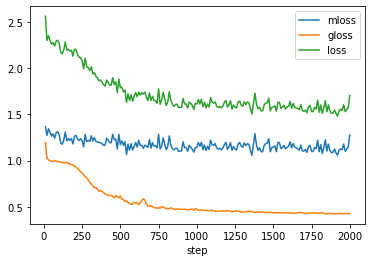

In [48]:
plugin.loss_history.plot()

In [51]:
plugin.model.generate(8)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,53.753993,-2.475239,0.404968,406.898386,1.788962,450.073724,1221.551077,5.697177,12.451377,14.835445,81.515696,0.0
1,241.769932,-33.905933,7.440188,1722.536053,48.034556,1312.264457,2141.119368,31.259074,83.654749,28.591759,489.172674,3.0
2,25.344904,0.769463,-11.237007,-335.794326,-3.595284,-234.179124,382.907515,7.637684,17.748300,3.380296,73.701048,1.0
3,15.635557,-28.371864,-19.808469,800.088446,61.404066,-596.053591,-1749.797505,28.376345,-71.868790,-14.556346,-38.315179,1.0
4,-0.796959,-8.546869,-4.726590,128.343028,1.083628,-288.352104,1184.680273,8.081500,23.012828,2.168597,36.672840,0.0
5,-31.203381,-39.052177,-57.651032,1269.158981,-22.793850,101.490751,-661.997823,5.012738,19.615822,26.791456,-63.773678,3.0
6,-120.526480,-49.314650,-67.642982,650.136816,65.155843,598.106999,-3468.753037,3.750566,52.556860,-108.310847,-91.816310,3.0
7,13.172627,-7.196406,-20.153565,746.262383,-30.846688,1592.815397,1610.699379,-15.576660,27.319692,45.376814,135.871422,0.0


### Conditional data generation

A conditional variable `cond` can be provided to the `fit` method. It can be either a column name in the dataset or a custom array. The model will then learn the conditional distribution of the dataset given `cond`. In this case, an array must be provided as the `cond` argument of the `generate` method.

In [43]:
plugin.fit(loader, cond='quality')

[2023-03-27T18:03:45.005934+0200][38480][INFO] Step 100: MLoss: 0.9066 GLoss: 1.0013 Sum: 1.9079000000000002
[2023-03-27T18:03:51.387087+0200][38480][INFO] Step 200: MLoss: 0.4735 GLoss: 1.0112 Sum: 1.4847000000000001
[2023-03-27T18:03:59.107456+0200][38480][INFO] Step 300: MLoss: 0.4567 GLoss: 1.001 Sum: 1.4577
[2023-03-27T18:04:05.835508+0200][38480][INFO] Step 400: MLoss: 0.2715 GLoss: 0.9856 Sum: 1.2571
[2023-03-27T18:04:12.739590+0200][38480][INFO] Step 500: MLoss: 0.2193 GLoss: 0.9046 Sum: 1.1239
[2023-03-27T18:04:19.417762+0200][38480][INFO] Step 600: MLoss: 0.0143 GLoss: 0.8463 Sum: 0.8606
[2023-03-27T18:04:26.022729+0200][38480][INFO] Step 700: MLoss: 0.0048 GLoss: 0.7509 Sum: 0.7557
[2023-03-27T18:04:32.757598+0200][38480][INFO] Step 800: MLoss: 0.0083 GLoss: 0.7102 Sum: 0.7185
[2023-03-27T18:04:39.550873+0200][38480][INFO] Step 900: MLoss: 0.0029 GLoss: 0.675 Sum: 0.6779000000000001
[2023-03-27T18:04:46.573464+0200][38480][INFO] Step 1000: MLoss: 0.0039 GLoss: 0.6414 Sum: 0.

<AxesSubplot: xlabel='step'>

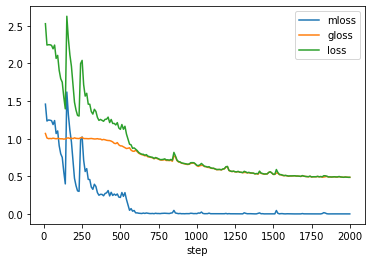

In [44]:
plugin.loss_history.plot()

In [45]:
outcome = np.array([3, 4, 5, 6, 7, 8, 9])
outcome

array([3, 4, 5, 6, 7, 8, 9])

In [46]:
plugin.generate(len(outcome), cond=outcome)

[2023-03-27T18:05:59.734678+0200][38480][INFO] [alcohol] quality loss for constraints le = 14.2. Remaining 5. prev length 7. Original dtype float64.
[2023-03-27T18:05:59.737612+0200][38480][INFO] [alcohol] quality loss for constraints ge = 8.0. Remaining 0. prev length 5. Original dtype float64.
[2023-03-27T18:06:00.157952+0200][38480][INFO] [alcohol] quality loss for constraints le = 14.2. Remaining 3. prev length 7. Original dtype float64.
[2023-03-27T18:06:00.160095+0200][38480][INFO] [alcohol] quality loss for constraints ge = 8.0. Remaining 0. prev length 3. Original dtype float64.
[2023-03-27T18:06:00.484737+0200][38480][INFO] [alcohol] quality loss for constraints le = 14.2. Remaining 3. prev length 7. Original dtype float64.
[2023-03-27T18:06:00.485757+0200][38480][INFO] [alcohol] quality loss for constraints ge = 8.0. Remaining 0. prev length 3. Original dtype float64.
[2023-03-27T18:06:00.786487+0200][38480][INFO] [alcohol] quality loss for constraints le = 14.2. Remaining 1.

KeyboardInterrupt: 

## Congratulations!

Congratulations on completing this notebook tutorial! If you enjoyed this and would like to join the movement towards Machine learning and AI for medicine, you can do so in the following ways!

### Star [Synthcity](https://github.com/vanderschaarlab/synthcity) on GitHub

- The easiest way to help our community is just by starring the Repos! This helps raise awareness of the tools we're building.


### Checkout other projects from vanderschaarlab
- [HyperImpute](https://github.com/vanderschaarlab/hyperimpute)
- [AutoPrognosis](https://github.com/vanderschaarlab/autoprognosis)
